# Optimizing BIke AllocatIons Problem - Preperation of Dataset

#### Mustafa Kerem Bulut - 150220303
#### Ömer Faruk San - 150220307
#### Abdullah Vefa Yankın - 150220318

In [1]:
import pandas as pd
import datetime
import json
import matplotlib.pyplot as plt

### Converting xlsx to csv

In [ ]:
char_map = {
    "Ã–": "Ö", "Ã¶": "ö",
    "Å": "Ş", "ÅŸ": "ş",
    "Ãœ": "Ü", "Ã¼": "ü",
    "Ä°": "İ", "Ä±": "ı",
    "Ã‡": "Ç", "Ã§": "ç",
    "Ä": "Ğ", "ÄŸ": "ğ"
}
def fix_encoding_issues(text):
    if isinstance(text, str):
        for bad, good in char_map.items():
            text = text.replace(bad, good)
    return text
excel_file = '2022_2023_kiralikbisiklet.xlsx'
all_sheets = pd.read_excel(excel_file, sheet_name=None)
combined_df = pd.concat(all_sheets.values(), ignore_index=True)
cleaned_df = combined_df.map(fix_encoding_issues)
cleaned_df.to_csv('2022_2023_kiralikbisiklet_cleaned.csv', index=False, encoding='utf-8-sig')

In [3]:
df = pd.read_csv('2022_2023_kiralikbisiklet_cleaned.csv', encoding='utf-8-sig')
df.head()

C:\Users\bulut\AppData\Local\Temp\ipykernel_19004\1109112506.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2022_2023_kiralikbisiklet_cleaned.csv', encoding='utf-8-sig')


,BikeId,Rental Start Date,Rental End Date,Duration,Fare (in Cents),Starting Location,Ending Location,Distance Traveled (m),Starting Station,Ending Station,"BikeId,Rental Start Date,Rental End Date,Duration,Email,User Name,Fare (in Cents),Starting Location,Ending Location,Distance Traveled (m),Starting Station,Ending Station",Email,User Name
0,1071,2023-12-13 10:01:00,2023-12-13 10:12:00,00:10:49,200,"37.8658189,32.4890395","37.86301040649414,32.47032928466797",1671.0,KON 1002 - Balık Hali,KON 1002 - Balık Hali,NaN,NaN,NaN
1,1850,2023-12-13 09:42:00,2023-12-13 09:48:00,00:06:24,200,"37.8746786,32.4285893","37.86896896362305,32.43614959716797",937.0,KON 2011 - Eski Tıp Fakültesi,KON 2017 - MERAM YAKA ÖNCÜ DÜĞÜN SALONU KARŞISI,NaN,NaN,NaN
2,1387,2023-12-13 08:10:00,2023-12-13 08:17:00,00:07:50,200,"37.9560437,32.4959829","37.94829177856445,32.494041442871094",878.0,KON 1058 - Akçaağaç Park Önü Yürüyüş Alanı,KON 1084 - Real Kavşağı Orta Refüj,NaN,NaN,NaN
3,1613,2023-12-13 07:26:00,2023-12-13 07:32:00,00:06:23,200,"37.8712299,32.490004","37.87942123413086,32.488441467285156",1174.0,KON 2020 - CAMLI KÖŞK,NaN,NaN,NaN,NaN
4,1666,2023-12-13 07:20:00,2023-12-13 07:29:00,00:09:27,200,"37.8782728,32.4595638","37.892459869384766,32.476131439208984",2145.0,KON 2029 - MERAM YAKA CİHERCİ BAHATTİN KAVŞAK,NaN,NaN,NaN,NaN


In [14]:
stations_df = pd.read_csv('station_capacities.csv', encoding='utf-8-sig')
stations_df.head()

,station_id,station_code,station_capacity
0,1,KON 1001,12
1,2,KON 1002,12
2,3,KON 1006,12
3,4,KON 1011,18
4,5,KON 1015,12


### Removing rows with missing or invalid data

In [ ]:
cleaned_df = df[["Rental Start Date", "Rental End Date", "Starting Station", "Ending Station"]]
cleaned_df = cleaned_df.dropna(subset=['Starting Station', 'Ending Station'])
cleaned_df = cleaned_df[cleaned_df['Starting Station'].apply(lambda x: isinstance(x, str) and x.startswith('KON'))]
cleaned_df = cleaned_df[cleaned_df['Ending Station'].apply(lambda x: isinstance(x, str) and x.startswith('KON'))]

starting_stations = cleaned_df['Starting Station'].unique()
ending_stations = cleaned_df['Ending Station'].unique()
missing_stations_codes = ["KON 2005", "KON 3000"]
cleaned_df = cleaned_df[~cleaned_df['Starting Station'].str.contains('|'.join(missing_stations_codes))]
cleaned_df = cleaned_df[~cleaned_df['Ending Station'].str.contains('|'.join(missing_stations_codes))]

### Calculating hourly usage data for every station

In [16]:
### HOURLY USAGE DATA ####
station_usage_data = {}
for index, station in stations_df.iterrows():
    station_usage_data[station['station_code']] = {}
    for i in range(0, 24):
        station_usage_data[station['station_code']][i] = [0, 0]  # [rental count, return count]

explored_day_count = 0
explored_days = []
data_count = 0

for index, row in cleaned_df.iterrows():
    start_station = row['Starting Station']
    end_station = row['Ending Station']
    start_station_code = start_station.split('-')[0][:8]
    end_station_code = end_station.split('-')[0][:8]

    start_date = row['Rental Start Date']
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    
    end_date = row['Rental End Date']
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    data_count += 1

    if start_date.date() not in explored_days:
        explored_days.append(start_date.date())
        explored_day_count += 1
    if end_date.date() not in explored_days:
        explored_days.append(end_date.date())
        explored_day_count += 1

    start_hour = start_date.hour
    end_hour = end_date.hour

    station_usage_data[start_station_code][start_hour][0] += 1
    station_usage_data[end_station_code][end_hour][1] += 1

station_total_usage_data = station_usage_data.copy()

with open('station_total_usage_data.json', 'w') as f:
    json.dump(station_total_usage_data, f, indent=4)


station_average_usage_data = station_usage_data.copy()
for station_code, usage_data in station_average_usage_data.items():
    for hour, counts in usage_data.items():
        station_average_usage_data[station_code][hour][0] /= explored_day_count
        station_average_usage_data[station_code][hour][1] /= explored_day_count

with open('station_average_usage_data.json', 'w') as f:
    json.dump(station_average_usage_data, f, indent=4)


print(f"Total data count: {data_count}")
print(f"Total day count: {explored_day_count}")

Total data count: 29904
Total day count: 223


### Plotting hourly data

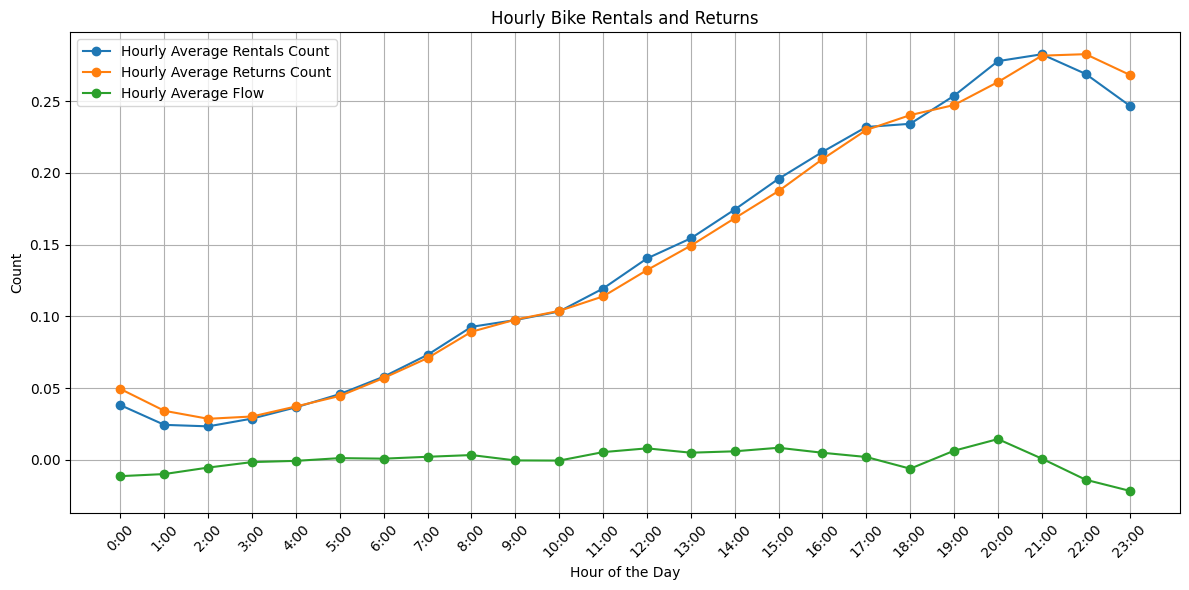

In [17]:
hourly_rentals = list(range(24))
hourly_returns = list(range(24))
hourly_flows = list(range(24))
for station_code, usage_data in station_average_usage_data.items():
    for hour in range(24):
        hourly_rentals[hour] += usage_data[hour][0]
        hourly_returns[hour] += usage_data[hour][1]

for i in range(24):
    hourly_rentals[i] = hourly_rentals[i] / len(station_average_usage_data)
    hourly_returns[i] = hourly_returns[i] / len(station_average_usage_data)
    hourly_flows[i] = hourly_rentals[i] - hourly_returns[i]


plt.figure(figsize=(12, 6))
plt.plot(hourly_rentals, label='Hourly Average Rentals Count', marker='o')
plt.plot(hourly_returns, label='Hourly Average Returns Count', marker='o')
plt.plot(hourly_flows, label='Hourly Average Flow', marker='o')
plt.title('Hourly Bike Rentals and Returns')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(range(24), [f"{i}:00" for i in range(24)], rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Calculating daily usage data

In [18]:
### DAILY USAGE DATA ####
station_usage_data = {}
for index, station in stations_df.iterrows():
    station_usage_data[station['station_code']] = [0,0] # [rental count, return count]

explored_day_count = 0
explored_days = []
data_count = 0

for index, row in cleaned_df.iterrows():
    start_station = row['Starting Station']
    end_station = row['Ending Station']
    start_station_code = start_station.split('-')[0][:8]
    end_station_code = end_station.split('-')[0][:8]

    start_date = row['Rental Start Date']
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    
    end_date = row['Rental End Date']
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    data_count += 1

    if start_date.date() not in explored_days:
        explored_days.append(start_date.date())
        explored_day_count += 1
    if end_date.date() not in explored_days:
        explored_days.append(end_date.date())
        explored_day_count += 1

    station_usage_data[start_station_code][0] += 1
    station_usage_data[end_station_code][1] += 1

daily_usage_data = pd.DataFrame(index=stations_df['station_code'], columns=['avg_rental', 'avg_return'])
for station_code, usage in station_usage_data.items():
    daily_usage_data.at[station_code, 'avg_rental'] = usage[0] / explored_day_count
    daily_usage_data.at[station_code, 'avg_return'] = usage[1] / explored_day_count

daily_usage_data.to_csv('station_daily_average_usage_data.csv', encoding='utf-8-sig')

### Plotting daily data

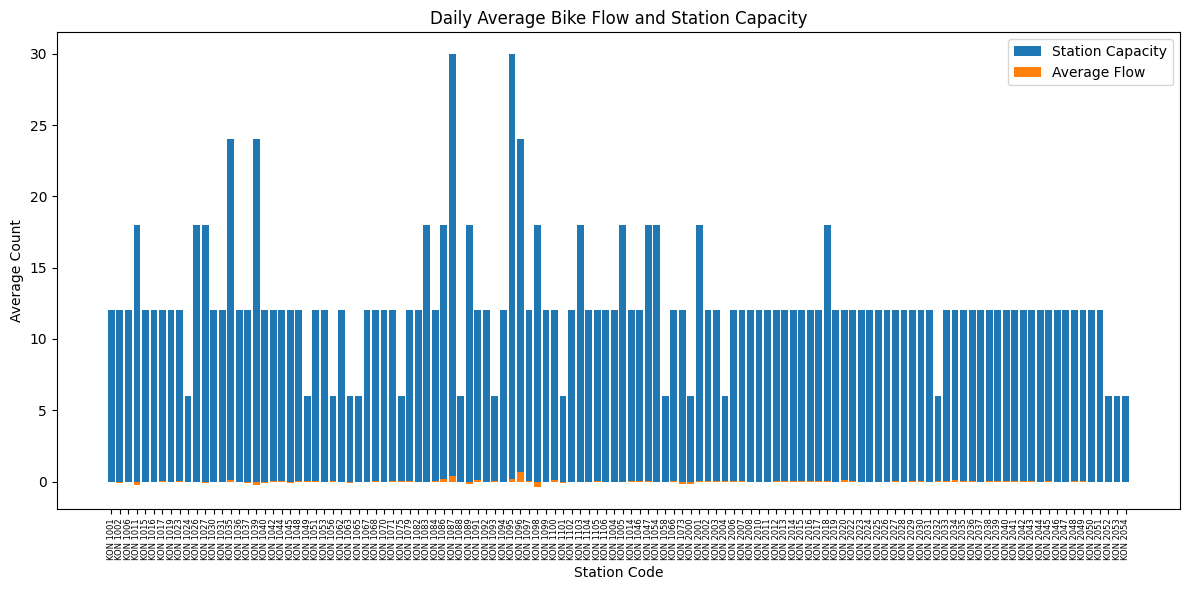

In [30]:
plt.figure(figsize=(12, 6))
plt.bar(stations_df['station_code'], stations_df['station_capacity'], label='Station Capacity')
plt.bar(daily_usage_data.index, daily_usage_data['avg_rental'] - daily_usage_data['avg_return'], label='Average Flow')
plt.title('Daily Average Bike Flow and Station Capacity')
plt.xlabel('Station Code')
plt.ylabel('Average Count')
plt.legend()
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

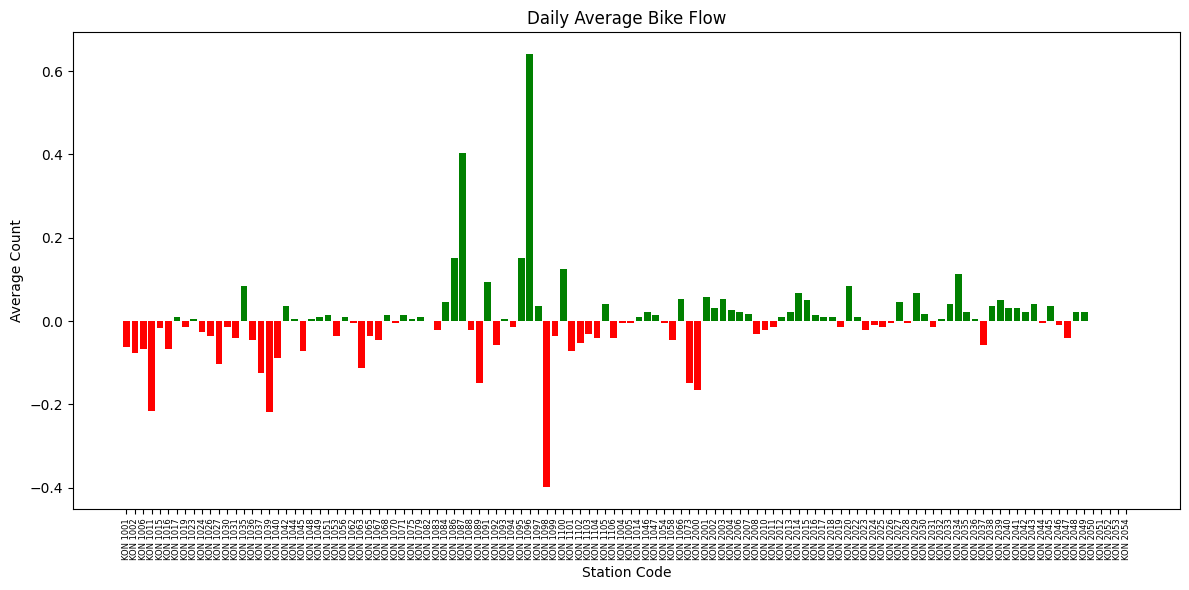

In [34]:
plt.figure(figsize=(12, 6))
# plt.bar(stations_df['station_code'], stations_df['station_capacity'], label='Station Capacity', color='lightblue', alpha=0.5)
flow = daily_usage_data['avg_rental'] - daily_usage_data['avg_return']
colors = ['green' if val > 0 else 'red' for val in flow]
plt.bar(daily_usage_data.index, flow, label='Average Flow', color=colors)
plt.title('Daily Average Bike Flow')
# plt.legend()
plt.xlabel('Station Code')
plt.ylabel('Average Count')
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

### Weekly usage data

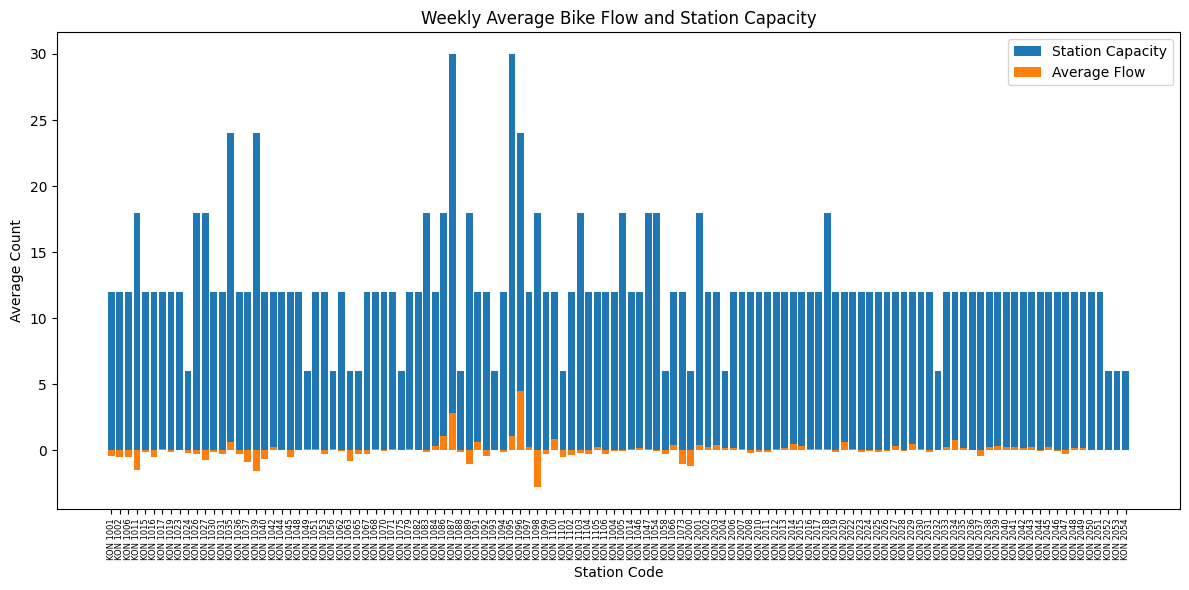

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(stations_df['station_code'], stations_df['station_capacity'], label='Station Capacity')
plt.bar(daily_usage_data.index, 7*(daily_usage_data['avg_rental'] - daily_usage_data['avg_return']), label='Average Flow')
plt.title('Weekly Average Bike Flow and Station Capacity')
plt.legend()
plt.xlabel('Station Code')
plt.ylabel('Average Count')
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

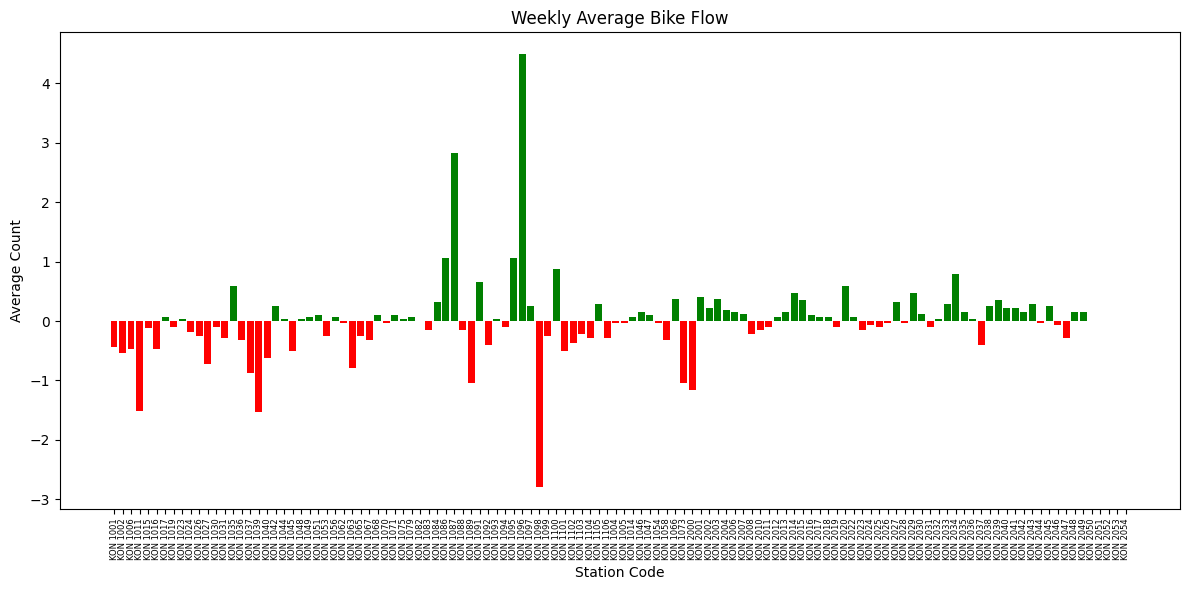

In [32]:
plt.figure(figsize=(12, 6))
# plt.bar(stations_df['station_code'], stations_df['station_capacity'], label='Station Capacity', color='lightblue', alpha=0.5)
flow = 7 * (daily_usage_data['avg_rental'] - daily_usage_data['avg_return'])
colors = ['green' if val > 0 else 'red' for val in flow]
plt.bar(daily_usage_data.index, flow, label='Average Flow', color=colors)
plt.title('Weekly Average Bike Flow')
# plt.legend()
plt.xlabel('Station Code')
plt.ylabel('Average Count')
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()